# Programming for Data Analytics (CA_TWO) - GroupA

Group Memebers

*   Chirag Sushil Gupta - 10623123
*   Chukwuebuka Uwaoma - 10621864
*   Dipanshu Vora - 10611045


In [481]:
# Import necesarry libraries
import tweepy
import os
from dotenv import load_dotenv
import pandas as pd
import mysql.connector
import datetime
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

### API configuration

In [482]:
# Load dotenv and read tokens and enviroment variables from .env file
load_dotenv()
api_key = os.getenv('api_key')
api_secret_key = os.getenv('api_secret_key')
access_token = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')

In [483]:
# Connect to twitter using tweepy API and stored tokens
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

### Data Extraction

In [484]:
# Pulls tweets based on search query and geocode location
tweetlist = []
geocode="53.1424,-7.6921,300km"   # Ireland's geocode
filter =  '-filter:retweets AND -filter:replies'
query = '(housing) OR (housing crisis) OR (rent)'
today = datetime.date.today()

# adds tweets to a dataframe
column_names = ["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location"]
df = pd.DataFrame(columns=column_names)

# Pulling tweets of a week from today's date
for i in range(6,-2,-1):
    # Looping through each day
    until = today - datetime.timedelta(days = i)
    date = until.strftime("%Y-%m-%d")

    # Retrieving the tweets using api by passing the necessary parameters
    for tweet in tweepy.Cursor(api.search_tweets, q=query+filter, geocode=geocode, lang='en', tweet_mode="extended", until = date).items(50):
        new_row = pd.Series({
        "id": tweet.id, 
        "created_at":tweet.created_at,
        "username": tweet.user.screen_name, 
        "tweet": tweet.full_text, 
        "retweet_count": tweet.retweet_count, 
        "favorite_count": tweet.favorite_count,
        "user_location":tweet.user.location,
        })
        
        # get the index of the last row
        last_row_index = len(df)
        # add the new row to the DataFrame using .iloc[]
        df.loc[last_row_index] = new_row
df.head()

,id,created_at,username,tweet,retweet_count,favorite_count,user_location
0,1647373650369159170,2023-04-15 22:57:39+00:00,Emmetseankelly,What is it about Ireland that we live rent fre...,0,0,"Dublin City, Ireland"
1,1647361703359684609,2023-04-15 22:10:11+00:00,ken_keenan,Brits mad because we’re living in their heads ...,1,3,"Dublin, Ireland"
2,1647354740664139776,2023-04-15 21:42:31+00:00,BarryMcElduff,Incredible finale to Golden Apples Players pro...,0,14,"Carrickmore, Ireland"
3,1647354254091333633,2023-04-15 21:40:35+00:00,sligococo,Sligo County Council is having an amazing nigh...,1,9,Sligo
4,1647350946240819201,2023-04-15 21:27:26+00:00,chamney,But no adequate supply of homes to rent or buy...,0,0,Wicklow


### Data Preprocessing

In [485]:
# Dimension of the dataset
df.shape

(400, 7)

In [486]:
# Checking for duplicate values in the dataset
sum(df.duplicated())

0

In [487]:
# Checking for null values in the dataset
(df.isnull().sum())

id                0
created_at        0
username          0
tweet             0
retweet_count     0
favorite_count    0
user_location     0
dtype: int64

In [488]:
# Formatting the date to dd/mm/YYYY format
def formatDate(timestamp):
    # As the timestamp retrieved from the api is already in DatetimeIndex form, simply converting it to desired format
    # and finally, transforming it to datetime again
    formatted_date = timestamp.strftime("%Y-%m-%d")
    formatted_date = datetime.datetime.strptime(formatted_date, "%Y-%m-%d")
    return formatted_date

# Getting only the words and numbers from the tweet that contains links, special symbols, emojis, etc.
def cleanTweet(tweet):
    # Converting the string to lowercase and replacing the ' with blank
    removed_apostrophe = tweet.lower().replace("'","")
    # Using regex pattern to replace the links, <html> tags and &amp; symbol (seen frequently in the tweets) with blank
    removed_links_tags_frequentsymbol = re.sub("(https?://\S+)|(<[\w]+>)|(&amp;)","",removed_apostrophe)
    # This regex pattern returns a list that contains all the words and numbers in the tweet
    cleaned_tweet = re.findall("([a-z0-9]+)", removed_links_tags_frequentsymbol)
    cleaned_tweet = " ".join(cleaned_tweet)
    return cleaned_tweet

# Applying respective functions to both columns in the dataset
df["created_at"] = df["created_at"].apply(formatDate)
df["cleaned_tweet"] = df["tweet"].apply(cleanTweet)
df.head()

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
0,1647373650369159170,2023-04-15,Emmetseankelly,What is it about Ireland that we live rent fre...,0,0,"Dublin City, Ireland",what is it about ireland that we live rent fre...
1,1647361703359684609,2023-04-15,ken_keenan,Brits mad because we’re living in their heads ...,1,3,"Dublin, Ireland",brits mad because we re living in their heads ...
2,1647354740664139776,2023-04-15,BarryMcElduff,Incredible finale to Golden Apples Players pro...,0,14,"Carrickmore, Ireland",incredible finale to golden apples players pro...
3,1647354254091333633,2023-04-15,sligococo,Sligo County Council is having an amazing nigh...,1,9,Sligo,sligo county council is having an amazing nigh...
4,1647350946240819201,2023-04-15,chamney,But no adequate supply of homes to rent or buy...,0,0,Wicklow,but no adequate supply of homes to rent or buy


### Connecting to local SQL database

In [489]:
connection = mysql.connector.connect(host='localhost',
                                    database='ca',
                                    user='root',
                                    password='toor')

In [490]:
# SQL query to create a table and inserting the columns name in it.
mySql_insert_query = 'CREATE TABLE if not exists api (id int(22) primary key ,created_at DATE, \
                    username varchar(255),tweet TEXT(300),retweet_count INT,favorite_count INT, user_location varchar(255), cleaned_tweet TEXT(300));'

In [491]:
# Create a cursor object "cursor" to execute MySQL queries with.
# The "buffered=True" parameter sets up the cursor to buffer the results, which can be useful for large queries.
cursor = connection.cursor(buffered=True)

# Deleting all existing rows from the db
mySql_delete_query = "DELETE FROM api"
cursor.execute(mySql_delete_query)

# Use the cursor's "execute()" method to execute the MySQL query specified in the "mySql_insert_query" variable.
cursor.execute(mySql_insert_query)

# Commit the changes made to the MySQL database using the connection's "commit()" method.
connection.commit()

### Inserting and retrieving data from DB

In [492]:
# Using SQLAlchemy to communicate between python and database
engine = create_engine(os.getenv('db_string'))
df.to_sql('api', con = engine, if_exists = 'replace',index = False, chunksize = 1000)

400

In [493]:
# Data retrieve from DB and insert into pd df

# Define a MySQL query "sql_query" to select all columns from the "api" table.
sql_query = "SELECT * FROM api"

# Use the cursor's "execute()" method to execute the MySQL query.
cursor.execute(sql_query)

# Use the cursor's "fetchall()" method to fetch all the rows returned by the MySQL query.
result = cursor.fetchall()

# Convert the fetched rows into a Pandas DataFrame "data" using the "pd.DataFrame()" function.
data=pd.DataFrame(result)

# Rename the columns of the DataFrame using the "columns" attribute of the DataFrame.
data.columns=["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location", "cleaned_tweet"]

# Print the DataFrame "data" to the console.
data.head()

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet
0,1647373650369159170,2023-04-15,Emmetseankelly,What is it about Ireland that we live rent fre...,0,0,"Dublin City, Ireland",what is it about ireland that we live rent fre...
1,1647361703359684609,2023-04-15,ken_keenan,Brits mad because we’re living in their heads ...,1,3,"Dublin, Ireland",brits mad because we re living in their heads ...
2,1647354740664139776,2023-04-15,BarryMcElduff,Incredible finale to Golden Apples Players pro...,0,14,"Carrickmore, Ireland",incredible finale to golden apples players pro...
3,1647354254091333633,2023-04-15,sligococo,Sligo County Council is having an amazing nigh...,1,9,Sligo,sligo county council is having an amazing nigh...
4,1647350946240819201,2023-04-15,chamney,But no adequate supply of homes to rent or buy...,0,0,Wicklow,but no adequate supply of homes to rent or buy


### Data Analysis

In [494]:
# Download necessary resources from NLTK
# Tokenize and Lemmatize tweet words to base words
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def lemmatize_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(tweet)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return lemmatized_sentence

data['lemmatize_tweet'] = df['cleaned_tweet'].apply(lemmatize_tweet)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [495]:
# Grouping the user location by county/city

def get_county(location):
    # returns the county from the users location
    if location is None:
        return 'Other'
    if 'dublin' in location.lower():
        return 'Dublin'

    split = location.split(',')
    if len(split) > 2:
        return split[1].strip() 
    elif len(split) > 1:
        return split[0].strip() 
    else:
        if split[0].lower() != "ireland":
            return split[0].strip() 
        else: return 'Other'

data['user_location'] = df['user_location'].apply(get_county)
data.head()


,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet,lemmatize_tweet
0,1647373650369159170,2023-04-15,Emmetseankelly,What is it about Ireland that we live rent fre...,0,0,Dublin,what is it about ireland that we live rent fre...,ireland live rent free people head
1,1647361703359684609,2023-04-15,ken_keenan,Brits mad because we’re living in their heads ...,1,3,Dublin,brits mad because we re living in their heads ...,brit mad living head rent free send redcoat evict
2,1647354740664139776,2023-04-15,BarryMcElduff,Incredible finale to Golden Apples Players pro...,0,14,Carrickmore,incredible finale to golden apples players pro...,incredible finale golden apple player producti...
3,1647354254091333633,2023-04-15,sligococo,Sligo County Council is having an amazing nigh...,1,9,Sligo,sligo county council is having an amazing nigh...,sligo county council amazing night ireland com...
4,1647350946240819201,2023-04-15,chamney,But no adequate supply of homes to rent or buy...,0,0,Wicklow,but no adequate supply of homes to rent or buy,adequate supply home rent buy


**1) Wordcloud for all the tweets**

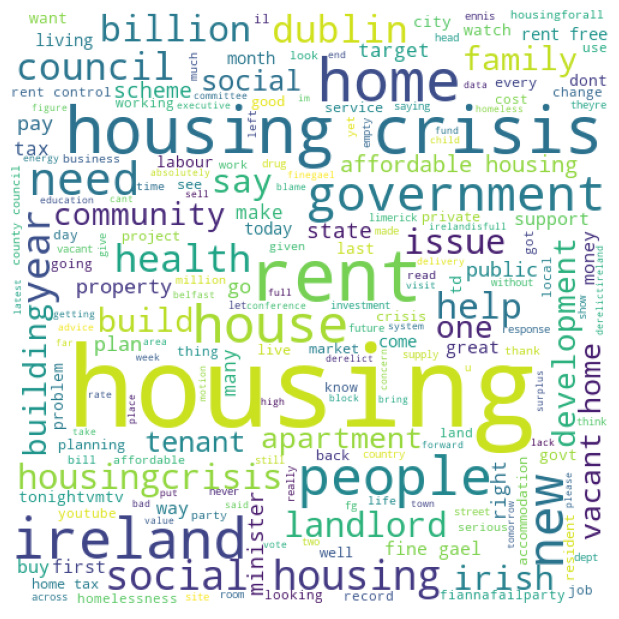

In [496]:
# Visualize wordcloud for all tweets for most occuring words

# Concatenate all tweets into a single string
all_tweets = ' '.join(data['lemmatize_tweet'])

# Generate a word cloud from the concatenated string
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**2) Wordcloud of tweets from 5 cities/counties with highest number of tweets**

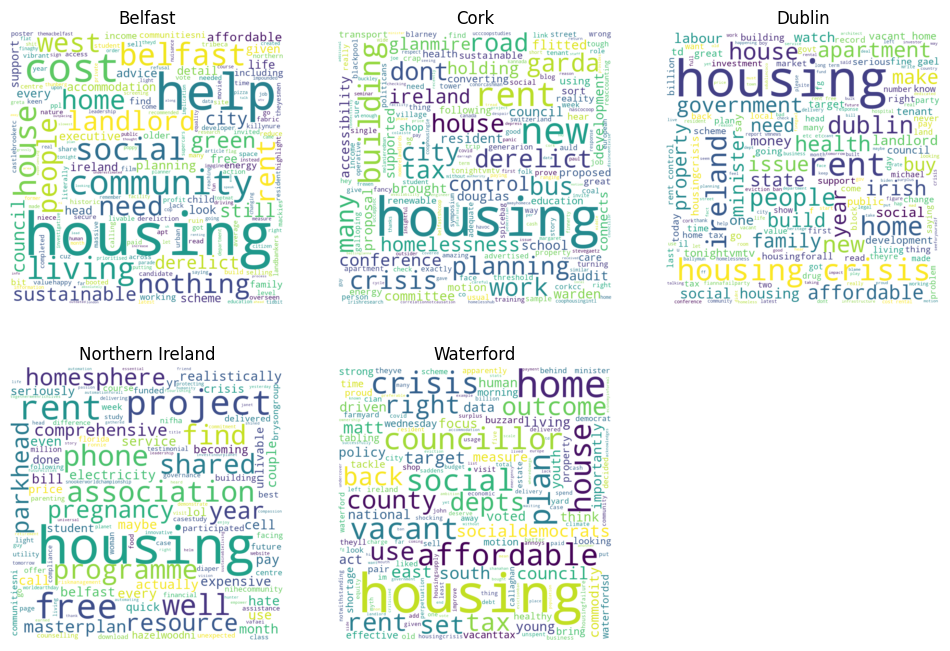

In [497]:
# Visualize wordcloud for top 5 county's by tweets

location_counts = data['user_location'].value_counts()
top_locations = location_counts[:5].index.tolist()
location_df = data[data['user_location'].isin(top_locations)].copy()

# Group the filtered DataFrame by location
grouped_data = location_df.groupby('user_location')['lemmatize_tweet'].apply(lambda x: ' '.join(x)).reset_index()
grouped_data = grouped_data.head(5)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[1][2].set_visible(False)

# Create a word cloud for each location and plot it in the corresponding subplot
for i, row in grouped_data.iterrows():
    location = row['user_location']
    text = row['lemmatize_tweet']
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    ax = axs[i // 3, i % 3]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(location)
    ax.axis('off')
    
# Show the plot
plt.show()


**3)Bar chart of 10 cities/counties with maximum number of tweets**

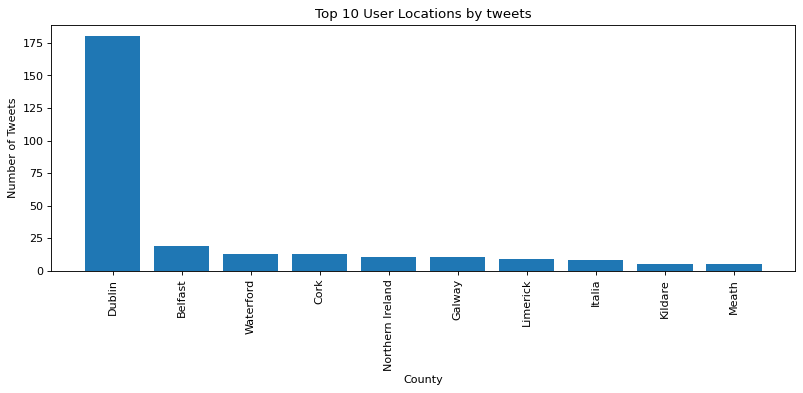

In [498]:
location_counts = data['user_location'].value_counts().nlargest(10)

# Plotting a bar chart of the same
plt.figure(figsize=(12, 4), dpi=80)
plt.bar(location_counts.index, location_counts.values)
plt.title('Top 10 User Locations by tweets')
plt.xlabel('County')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.show()

**4) Line plot of number of tweets per day**

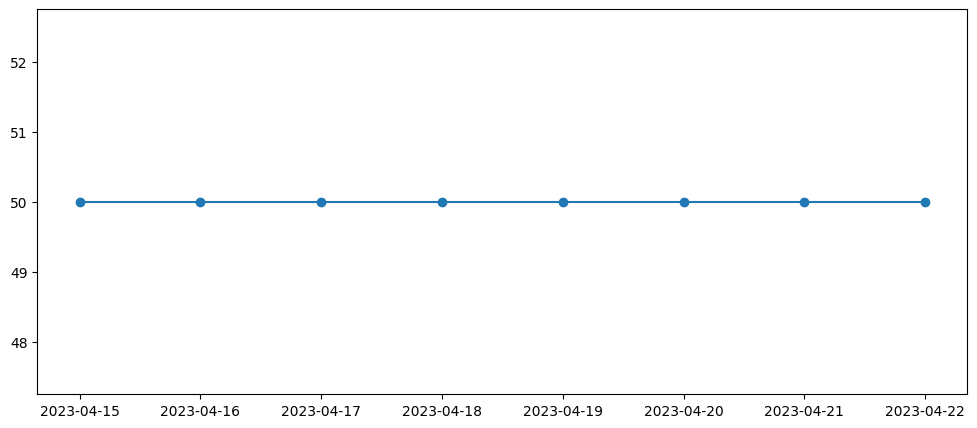

In [499]:
# Grouping by the created_at column and storing it into a series
date_groupby_day = data.groupby(pd.Grouper(key='created_at', freq='D')).size()

# Plotting the line plot
plt.figure(figsize=(12,5))
plt.plot(date_groupby_day,"-o")
plt.show()

**5) Tweet with maximum retweet count and all tweets (if exists) from the same username**

In [500]:
# Storing the tweet wiht max retweet count into another dataframe
max_retweets = data[data["retweet_count"] == max(data.retweet_count)].reset_index(drop=True)
max_retweets

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet,lemmatize_tweet
0,1648437136901963776,2023-04-18,frank_oconnor,"""Spain is aiming to help millions of young adu...",119,459,The real capital of Ireland,spain is aiming to help millions of young adul...,spain aiming help million young adult still li...


In [501]:
# Printing the full tweet
print(max_retweets.tweet[0])

"Spain is aiming to help millions of young adults still living with their parents to rent their own homes by offering them properties abandoned when its housing market collapsed a decade ago."

How about this for #DerelictIreland?

https://t.co/uJuqHDx5Oi


In [502]:
# All other tweets (if any) from the same username
data.loc[data.username == max_retweets.username[0]]

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet,lemmatize_tweet
34,1647205572251381765,2023-04-15,frank_oconnor,That Ireland is full of empty homes in a housi...,20,58,The real capital of Ireland,that ireland is full of empty homes in a housi...,ireland full empty home housing emergency dere...
165,1648437136901963776,2023-04-18,frank_oconnor,"""Spain is aiming to help millions of young adu...",119,459,The real capital of Ireland,spain is aiming to help millions of young adul...,spain aiming help million young adult still li...
193,1648398218378768384,2023-04-18,frank_oconnor,Listen to this &amp; its easy to understand wh...,16,37,The real capital of Ireland,listen to this its easy to understand why hous...,listen easy understand housing emergency recor...
280,1649081695906168833,2023-04-20,frank_oconnor,Boarding up homes are never a good look\nBut t...,8,29,The real capital of Ireland,boarding up homes are never a good look but th...,boarding home never good look look vandalistic...


**6) Tweet with maximum like count and all tweets (if exists) from the same username**

In [503]:
# Storing the tweet wiht max like count into another dataframe
max_likes = data[data["favorite_count"] == max(data.favorite_count)].reset_index(drop=True)
max_likes

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet,lemmatize_tweet
0,1648443466429652994,2023-04-18,Ceannabhain,Landlord changed banks. If tenant is telling t...,59,613,Dublin,landlord changed banks if tenant is telling th...,landlord changed bank tenant telling truth rep...


In [504]:
# Printing the full tweet
print(max_likes.tweet[0])

Landlord changed banks. If tenant is telling the truth, he repeatedly tried to contact landlord about rent bouncing and put money aside so that he could pay when landlord got in touch.

I believe the tenant btw, not the guy who turned up to threaten a family with a power tool. https://t.co/pHUTl3rSF5 https://t.co/aXx9CPqKcN


In [505]:
# All other tweets (if any) from the same username
data.loc[data.username == max_retweets.username[0]]

,id,created_at,username,tweet,retweet_count,favorite_count,user_location,cleaned_tweet,lemmatize_tweet
34,1647205572251381765,2023-04-15,frank_oconnor,That Ireland is full of empty homes in a housi...,20,58,The real capital of Ireland,that ireland is full of empty homes in a housi...,ireland full empty home housing emergency dere...
165,1648437136901963776,2023-04-18,frank_oconnor,"""Spain is aiming to help millions of young adu...",119,459,The real capital of Ireland,spain is aiming to help millions of young adul...,spain aiming help million young adult still li...
193,1648398218378768384,2023-04-18,frank_oconnor,Listen to this &amp; its easy to understand wh...,16,37,The real capital of Ireland,listen to this its easy to understand why hous...,listen easy understand housing emergency recor...
280,1649081695906168833,2023-04-20,frank_oconnor,Boarding up homes are never a good look\nBut t...,8,29,The real capital of Ireland,boarding up homes are never a good look but th...,boarding home never good look look vandalistic...
